In [11]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

abspath = os.path.abspath(os.getcwd())
finpath = Path(abspath).resolve().parent
parent_path = str(finpath) + '/'

final_df = pd.read_csv(parent_path + "FinalDF.csv")
adj_counties = pd.read_csv(parent_path + "AdjacentDelta.csv")
final_df["Population"] = np.sqrt(final_df["Population"]) / np.sqrt(final_df["Population"].max()) #Ask about specific transformation for weighting to use here

In [16]:
def standardize_df(df):
    df = df.select_dtypes(exclude=['object'])
    feature_cols = df.columns[2:]
    std_final_df = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, 2:]), columns=feature_cols)
    pop_df = df["Population"]
    return std_final_df, pop_df

def shuffle_data(data, labels, p):
    indices = np.random.permutation(len(data))
    return data[indices], labels[indices], p[indices]

def split_data(data, labels, p):
    size = len(data)
    index_eighty = int(size*0.8)
    train_data = data[:index_eighty]
    train_labels = labels[:index_eighty]
    train_p = p[:index_eighty]
    test_data = data[index_eighty:]
    test_labels = labels[index_eighty:]
    test_p = p[index_eighty:]
    return train_data, train_labels, train_p, test_data, test_labels, test_p

In [100]:
median_income = final_df["Median Household Income"].median()
df_upper_income = final_df[final_df["Median Household Income"] >= median_income]
df_lower_income = final_df[final_df["Median Household Income"] < median_income]
#print(df_upper_income["Population"])
#print(df_lower_income.shape)

# Here, our dataframes are not the same shapes because % Completed High School has many values at the median,
# but the number of observations in the dataframes are 1197 for the upper bracket and 1209 for the lower bracket,
# which we found to be acceptable for running our regression analysis on
median_edu = final_df["% Completed High School"].median()
df_upper_edu = final_df[final_df["% Completed High School"] > median_edu]
df_lower_edu = final_df[final_df["% Completed High School"] <= median_edu]

# Adjacent counties regression

adj_counties = adj_counties.select_dtypes(exclude=['object'])


# Standardizing values and creating all the matrices we need to run Lasso

df_lst = [final_df, df_upper_income, df_lower_income, df_upper_edu, df_lower_edu] #Want to add adj_counties to this list after Population column is added
params_lst = []
for frame in df_lst:
    std_frame, pop_df = standardize_df(frame)
    label_df = std_frame["% Smokers"]
    IV_df = std_frame["Cig Tax Rate"]
    features_df = std_frame.drop(columns=["% Smokers", "Cig Tax Rate"])
    p = np.array([pop_df]).T
    X = np.array(features_df)
    IV = np.array([IV_df]).T
    y = np.array([label_df]).T
    values = [X, IV, y, p]
    params_lst.append(values)
    print(p.shape)
    print(X.shape)
    print(IV.shape)

(2406, 1)
(2406, 48)
(2406, 1)
(1203, 1)
(1203, 48)
(1203, 1)
(1203, 1)
(1203, 48)
(1203, 1)
(1197, 1)
(1197, 48)
(1197, 1)
(1209, 1)
(1209, 48)
(1209, 1)


In [125]:
def cross_validation(params, lower, upper, lambdas, folds):
    X, IV, y, p = params
    lams = np.linspace(lower, upper, lambdas)
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(folds):
        X_s, y_s, p_s = shuffle_data(X, y, p)
        gen_params = split_data(X_s, y_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_X, train_y, train_p, test_X, test_y, test_p = gen_params
            B = cp.Variable((train_X.shape[1], 1))
            objective = cp.Minimize((train_p.T @ (train_y - train_X @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (test_p.T @ ((test_y - test_X @ betas) ** 2))
            sum_error += float(error)
        if sum_error < min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    print(best_lam)
    lams = np.linspace(0,0.5,150)
    plt.plot(lams, error_lst)
    plt.show()


0.0


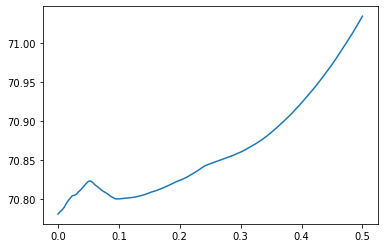

In [126]:
cross_validation(params_lst[0], 0, 0.5, 150, 20)

In [108]:
best_lams2 = []
error_lsts2 = []
upper_bounds2 = [0.5, 1, 1, 2, 1] #Adjust based on simple results
for i, params in enumerate(params_lst):
    X, IV, y, p = params
    lams = np.linspace(0,upper_bounds2[i],100) #Set to 100 for final run
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(20): #Set to 20 for final run
        X_s, IV_s, p_s = shuffle_data(X, IV, p)
        gen_params = split_data(X_s, IV_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_X, train_IV, train_p, test_X, test_IV, test_p = gen_params
            B = cp.Variable((train_X.shape[1], 1))
            objective = cp.Minimize(train_p.T @ ((train_IV - train_X @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (test_p.T @ ((test_IV - test_X @ betas) ** 2))
            sum_error += float(error)
        if sum_error <= min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    best_lams2.append(best_lam)
    error_lsts2.append(error_lst)
print(best_lams2)


[0.08108108108108109, 0.5, 0.02702702702702703, 1.5945945945945947, 0.13513513513513514]


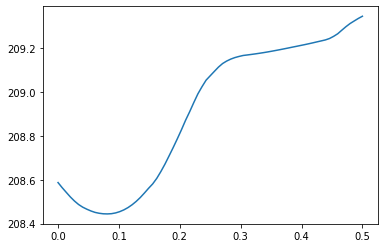

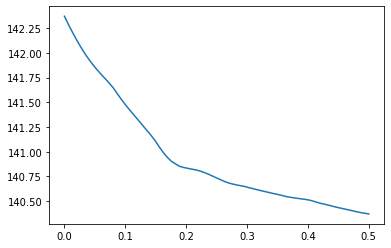

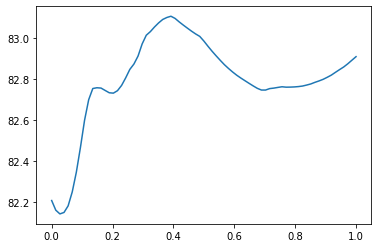

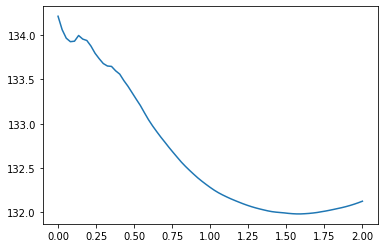

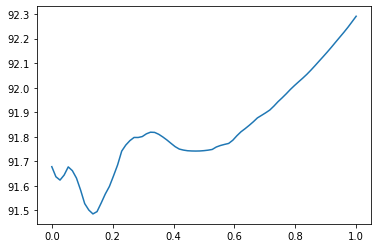

In [110]:
for i, error_lst in enumerate(error_lsts2):
    lams = np.linspace(0,upper_bounds2[i],75)
    plt.plot(lams, error_lst)
    plt.show()